# Adaptive Frequency tracking using NLMS and NLMS combiner

In [49]:
%matplotlib qt
import numpy as np  
import matplotlib.pyplot as plt

plt.rcParams.update({
     'font.size': 12, 
     'mathtext.fontset': 'cm',
     'font.family': 'Times New Roman',
})

In [43]:
simtime = 4 # seconds
runs = 200

fs = 960 # Hz
f_nom = 60 # Hz
amp = 1 # Volts
fm = 0.2
kx = 0.1
ka = 0.1
SNR = 60 # dB

step_freq= True
ramp_freq= False

step_amplitude = False
modulate_amplitude = False

step_phase = False
modulate_phase = False


T = simtime * fs
n = np.arange(T)

##### Signal Frequency Generation ######
if ramp_freq:
    inc = 1
    f_a = f_nom - inc*simtime/2
    f_b = f_nom + inc*simtime/2
    f = np.linspace(f_a, f_b, int(T))/fs
elif step_freq:
    f = np.zeros(T)
    f[:int(T/2)] = f_nom/fs
    f[int(T/2):] = (f_nom + 2)/fs
else:
    f = np.ones(T) * (f_nom )/fs
########################################

##### Signal Amplitude Generation ######
if step_amplitude:
    A = np.ones(T) * amp
    A[int(T/2):] *= 1.1
else:
    A = np.ones(T) * amp

if modulate_amplitude:
    A = A + kx*np.cos(2 * np.pi * (fm/fs) * n)

s_v2 = A**2/(2 * 10**(SNR/10))
#########################################

##### Signal Phase Generation ###########
phi = np.zeros(T)
if step_phase:
    phi[int(T/2):] = np.pi/18

if modulate_phase:
    phi = phi + ka * np.cos((2 * np.pi * (fm/fs) * n) - np.pi)
#########################################

## NLMS

In [6]:
# NLMS Algorithm for Frequency Estimation
M = 15
mu = 0.11
eps = 1e-6

se = np.zeros((runs, T))
freq_se = np.zeros((runs, T))
f_NLMS = np.zeros((runs, T))

for k in range(runs):

    x = np.zeros(T)
    psi = np.zeros(T)
    v = np.random.randn(T)*np.sqrt(s_v2)
    xim1 = np.zeros((1, M))
    c_NLMS = np.zeros((M, 1))

    for i in range(T):
        psi[i] = 2 * np.pi * np.sum(f[:i+1])
        x[i] = A[i] * np.cos(psi[i] + phi[i]) + v[i]
        
        if i > M:
            xim1[0,:] = x[i-1:i-M-1:-1]

            error = x[i] - (xim1 @ c_NLMS).item()
            se[k, i] = error**2
            freq_se[k, i] = (f[i]*fs - f_NLMS[k, i-1]*fs)**2

            c_NLMS = c_NLMS + ((mu * xim1.T) / (np.linalg.norm(xim1)**2 + eps)) * error

            q = np.concatenate((np.array([[1.0]]), -1*c_NLMS.T), axis=1)
            roots_q = np.roots(q[0,:])
            idx = np.argmin(np.abs(1 - np.abs(roots_q)))
            theta0 = np.angle(roots_q[idx])
            f_NLMS[k, i] = theta0/(2*np.pi) 
            

freq_mse_NLMS_db = 10*np.log10(np.mean(freq_se, axis=0))
mse_NLMS_db = 10*np.log10(np.mean(se, axis=0))

C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\505728539.py:38: RuntimeWarning: divide by zero encountered in log10
  freq_mse_NLMS_db = 10*np.log10(np.mean(freq_se, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\505728539.py:39: RuntimeWarning: divide by zero encountered in log10
  mse_NLMS_db = 10*np.log10(np.mean(se, axis=0))


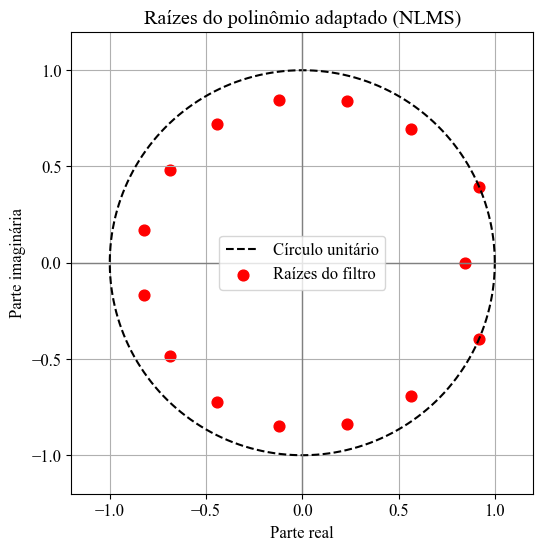

In [7]:
c_NLMS_final = c_NLMS.flatten()  # transforma (M,1) em vetor 1D
q = np.concatenate(([1.0], -c_NLMS_final))
roots_q = np.roots(q)

# Cria o círculo unitário
theta = np.linspace(0, 2*np.pi, 400)
unit_circle = np.exp(1j*theta)

# Figura
plt.figure(figsize=(6,6))
plt.plot(np.real(unit_circle), np.imag(unit_circle), 'k--', label='Círculo unitário')
plt.scatter(np.real(roots_q), np.imag(roots_q), color='red', s=60, label='Raízes do filtro')
plt.gca().set_aspect('equal', adjustable='box')

# Eixos e detalhes
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.xlabel('Parte real')
plt.ylabel('Parte imaginária')
plt.title('Raízes do polinômio adaptado (NLMS)')
plt.legend()
plt.grid(True)
plt.show()

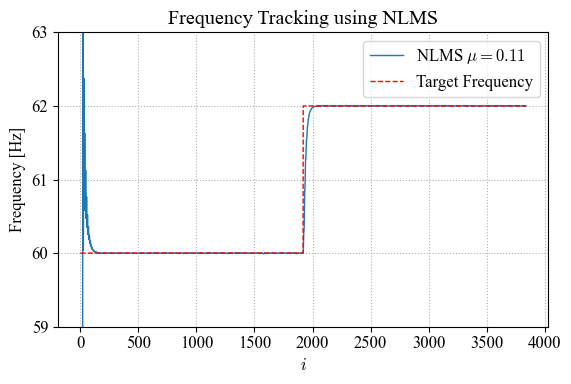

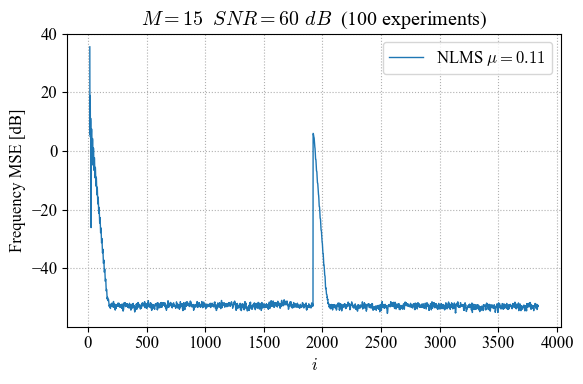

In [8]:
plt.figure(figsize=(6,4))
plt.title(rf'Frequency Tracking using NLMS')
plt.plot(f_NLMS[0,:]*fs, label=rf'NLMS $\mu={mu}$', linewidth=1)
plt.plot(f*fs, label=rf'Target Frequency', linestyle='--', color='r', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency [Hz]')
plt.ylim(min(f*fs)-1, max(f*fs)+1)
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.title(rf'$M={M}$  $SNR={SNR}~dB$  ({runs} experiments)')
plt.plot(freq_mse_NLMS_db, label=rf'NLMS $\mu={mu}$', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency MSE [dB]')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()


## NLMS Combination with SAME filter orders

In [9]:
# NLMS Combination algorithm for Frequency Estimation
M = 15
a_max = 4
beta = 0.9
mu_1 = 0.8
mu_2 = 0.08
mu_a = 5
eps = 1e-6

se_1 = np.zeros((runs, T))
freq_se_1 = np.zeros((runs, T))
f_1 = np.zeros((runs, T))
se_2 = np.zeros((runs, T))
freq_se_2 = np.zeros((runs, T))
f_2 = np.zeros((runs, T))
se_COMB = np.zeros((runs, T))
freq_se_COMB = np.zeros((runs, T))
f_COMB = np.zeros((runs, T))
lamb = np.zeros((runs, T))

for k in range(runs):   
    x = np.zeros(T)
    psi = np.zeros(T)
    v = np.random.randn(T)*np.sqrt(s_v2)
    xim1 = np.zeros((1, M))

    y_1 = np.zeros(T)
    e_1 = np.zeros(T)
    y_2 = np.zeros(T)
    e_2 = np.zeros(T)
    y = np.zeros(T)
    e = np.zeros(T)
    c_1 = np.zeros((M, 1))
    c_2 = np.zeros((M, 1))
    c_COMB = np.zeros((M, 1))
    a = 0.0
    p = eps

    for i in range(T):
        psi[i] = 2 * np.pi * np.sum(f[:i+1])
        x[i] = A[i] * np.cos(psi[i] + phi[i]) + v[i]
        
        if i > M:
            xim1[0,:] = x[i-1:i-M-1:-1]
            y_1[i] = (xim1 @ c_1).item()
            y_2[i] = (xim1 @ c_2).item()
            y[i] = (xim1 @ c_COMB).item()

            e_1[i] = x[i] - y_1[i]
            se_1[k,i] = e_1[i]**2
            freq_se_1[k,i] = (f[i]*fs - f_1[k,i-1]*fs)**2

            e_2[i] = x[i] - y_2[i]
            se_2[k,i] = e_2[i]**2
            freq_se_2[k,i] = (f[i]*fs - f_2[k,i-1]*fs)**2

            e[i] = x[i] - y[i]
            se_COMB[k,i] = e[i]**2
            freq_se_COMB[k,i] = (f[i]*fs - f_COMB[k,i-1]*fs)**2
            
            c_1 = c_1 + ((mu_1 * xim1.T) / (np.linalg.norm(xim1)**2 + eps)) * e_1[i]
            c_2 = c_2 + ((mu_2 * xim1.T) / (np.linalg.norm(xim1)**2 + eps)) * e_2[i]

            lamb[k, i] = 1/(1 + np.abs(np.exp(-a/2))**2)
            p = beta*p + (1 - beta)*(e_2[i] - e_1[i])**2
            a = a + (mu_a/p) * lamb[k,i]*(1 - lamb[k,i])*e[i]*(e_2[i] - e_1[i])
            a = np.clip(a, -a_max, a_max)
            
            c_COMB = lamb[k, i]*c_1 + (1 - lamb[k, i])*c_2

            q1 = np.concatenate((np.array([[1.0]]), -1*c_1.T), axis=1)
            roots_q1 = np.roots(q1[0,:])
            f_1[k, i] = np.angle(roots_q1[np.argmin(np.abs(1 - np.abs(roots_q1)))])/(2*np.pi) 

            q2 = np.concatenate((np.array([[1.0]]), -1*c_2.T), axis=1)
            roots_q2 = np.roots(q2[0,:])
            f_2[k, i] = np.angle(roots_q2[np.argmin(np.abs(1 - np.abs(roots_q2)))])/(2*np.pi)

            q_comb = np.concatenate((np.array([[1.0]]), -1*c_COMB.T), axis=1)
            roots_q_comb = np.roots(q_comb[0,:])
            f_COMB[k, i] = np.angle(roots_q_comb[np.argmin(np.abs(1 - np.abs(roots_q_comb)))])/(2*np.pi)
            

freq_mse_1_db = 10*np.log10(np.mean(freq_se_1, axis=0))
freq_mse_2_db = 10*np.log10(np.mean(freq_se_2, axis=0))
freq_mse_COMB_db = 10*np.log10(np.mean(freq_se_COMB, axis=0))
lamb_mean = np.mean(lamb, axis=0)

C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\311849930.py:84: RuntimeWarning: divide by zero encountered in log10
  freq_mse_1_db = 10*np.log10(np.mean(freq_se_1, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\311849930.py:85: RuntimeWarning: divide by zero encountered in log10
  freq_mse_2_db = 10*np.log10(np.mean(freq_se_2, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\311849930.py:86: RuntimeWarning: divide by zero encountered in log10
  freq_mse_COMB_db = 10*np.log10(np.mean(freq_se_COMB, axis=0))


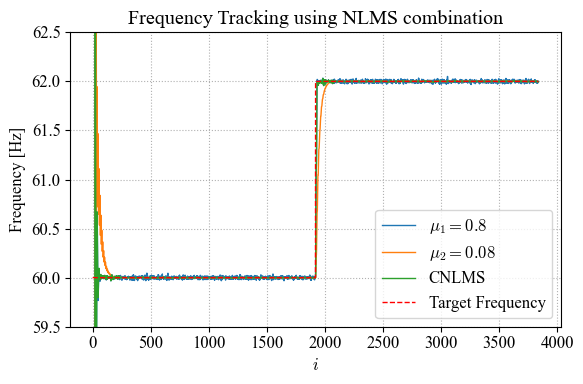

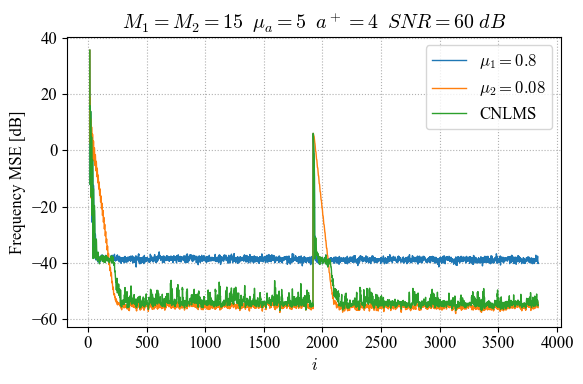

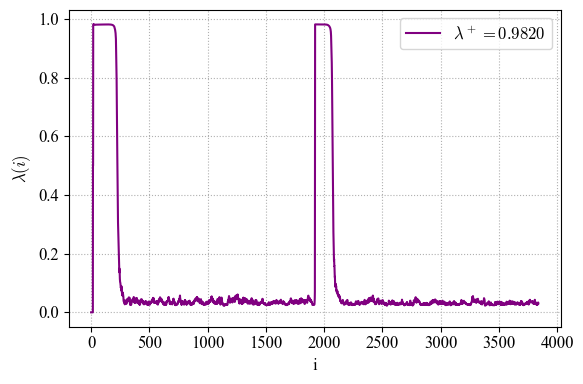

In [10]:
plt.figure(figsize=(6,4))
plt.title(rf'Frequency Tracking using NLMS combination')
plt.plot(f_1[0,:]*fs, label=rf'$\mu_1={mu_1}$', linewidth=1)
plt.plot(f_2[0,:]*fs, label=rf'$\mu_2={mu_2}$', linewidth=1)
plt.plot(f_COMB[0,:]*fs, label=rf'CNLMS', linewidth=1)
plt.plot(f*fs, label=rf'Target Frequency', linestyle='--', color='r', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency [Hz]')
plt.ylim(min(f*fs)-.5, max(f*fs)+.5)
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.title(rf'$M_1=M_2={M}$  $\mu_a={mu_a}$  $a^+={a_max}$  $SNR={SNR}~dB$')
plt.plot(freq_mse_1_db, label=rf'$\mu_1={mu_1}$', linewidth=1)
plt.plot(freq_mse_2_db, label=rf'$\mu_2={mu_2}$', linewidth=1)
plt.plot(freq_mse_COMB_db, label=rf'CNLMS', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency MSE [dB]')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(lamb_mean, color='purple', label=rf"$\lambda^+={max(lamb_mean):.4f}$")
plt.xlabel('i')
plt.ylabel(rf'$\lambda(i)$')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()


# NLMS combination using Coefficients Feedback

In [11]:
# NLMS Combination algorithm for Frequency Estimation
M = 15
a_max = 4
beta = 0.9
mu_1 = 0.8
mu_2 = 0.08
mu_a = 5
eps = 1e-6

L = 60

se_f1 = np.zeros((runs, T))
freq_se_f1 = np.zeros((runs, T))
f_f1 = np.zeros((runs, T))
se_f2 = np.zeros((runs, T))
freq_se_f2 = np.zeros((runs, T))
f_f2 = np.zeros((runs, T))
se_fCOMB = np.zeros((runs, T))
freq_se_fCOMB = np.zeros((runs, T))
f_fCOMB = np.zeros((runs, T))
flamb = np.zeros((runs, T))

for k in range(runs):   
    x = np.zeros(T)
    psi = np.zeros(T)
    v = np.random.randn(T)*np.sqrt(s_v2)
    xim1 = np.zeros((1, M))

    y_f1 = np.zeros(T)
    e_f1 = np.zeros(T)
    y_f2 = np.zeros(T)
    e_f2 = np.zeros(T)
    y = np.zeros(T)
    e = np.zeros(T)
    c_f1 = np.zeros((M, 1))
    c_f2 = np.zeros((M, 1))
    c_fCOMB = np.zeros((M, 1))
    a = 0.0
    p = eps

    for i in range(T):
        psi[i] = 2 * np.pi * np.sum(f[:i+1])
        x[i] = A[i] * np.cos(psi[i] + phi[i]) + v[i]
        
        if i > M:
            xim1[0,:] = x[i-1:i-M-1:-1]
            y_f1[i] = (xim1 @ c_f1).item()
            y_f2[i] = (xim1 @ c_f2).item()
            y[i] = (xim1 @ c_fCOMB).item()

            e_f1[i] = x[i] - y_f1[i]
            se_f1[k,i] = e_f1[i]**2
            freq_se_f1[k,i] = (f[i]*fs - f_f1[k,i-1]*fs)**2

            e_f2[i] = x[i] - y_f2[i]
            se_f2[k,i] = e_f2[i]**2
            freq_se_f2[k,i] = (f[i]*fs - f_f2[k,i-1]*fs)**2

            e[i] = x[i] - y[i]
            se_fCOMB[k,i] = e[i]**2
            freq_se_fCOMB[k,i] = (f[i]*fs - f_fCOMB[k,i-1]*fs)**2

            if i % L == 0:
                c_f1 = c_fCOMB.copy()
                c_f2 = c_fCOMB.copy()
            
            c_f1 = c_f1 + ((mu_1 * xim1.T) / (np.linalg.norm(xim1)**2 + eps)) * e_f1[i]
            c_f2 = c_f2 + ((mu_2 * xim1.T) / (np.linalg.norm(xim1)**2 + eps)) * e_f2[i]

            flamb[k, i] = 1/(1 + np.abs(np.exp(-a/2))**2)
            p = beta*p + (1 - beta)*(e_f2[i] - e_f1[i])**2
            a = a + (mu_a/p) * flamb[k,i]*(1 - flamb[k,i])*e[i]*(e_f2[i] - e_f1[i])
            a = np.clip(a, -a_max, a_max)
            
            c_fCOMB = flamb[k, i]*c_f1 + (1 - flamb[k, i])*c_f2

            q1 = np.concatenate((np.array([[1.0]]), -1*c_f1.T), axis=1)
            roots_q1 = np.roots(q1[0,:])
            f_f1[k, i] = np.angle(roots_q1[np.argmin(np.abs(1 - np.abs(roots_q1)))])/(2*np.pi) 

            q2 = np.concatenate((np.array([[1.0]]), -1*c_f2.T), axis=1)
            roots_q2 = np.roots(q2[0,:])
            f_f2[k, i] = np.angle(roots_q2[np.argmin(np.abs(1 - np.abs(roots_q2)))])/(2*np.pi)

            q_comb = np.concatenate((np.array([[1.0]]), -1*c_fCOMB.T), axis=1)
            roots_q_comb = np.roots(q_comb[0,:])
            f_fCOMB[k, i] = np.angle(roots_q_comb[np.argmin(np.abs(1 - np.abs(roots_q_comb)))])/(2*np.pi)
            

freq_mse_f1_db = 10*np.log10(np.mean(freq_se_f1, axis=0))
freq_mse_f2_db = 10*np.log10(np.mean(freq_se_f2, axis=0))
freq_mse_fCOMB_db = 10*np.log10(np.mean(freq_se_fCOMB, axis=0))
flamb_mean = np.mean(flamb, axis=0)

C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\1633738658.py:90: RuntimeWarning: divide by zero encountered in log10
  freq_mse_f1_db = 10*np.log10(np.mean(freq_se_f1, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\1633738658.py:91: RuntimeWarning: divide by zero encountered in log10
  freq_mse_f2_db = 10*np.log10(np.mean(freq_se_f2, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\1633738658.py:92: RuntimeWarning: divide by zero encountered in log10
  freq_mse_fCOMB_db = 10*np.log10(np.mean(freq_se_fCOMB, axis=0))


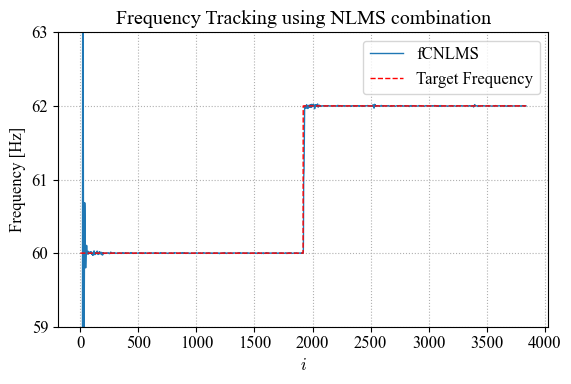

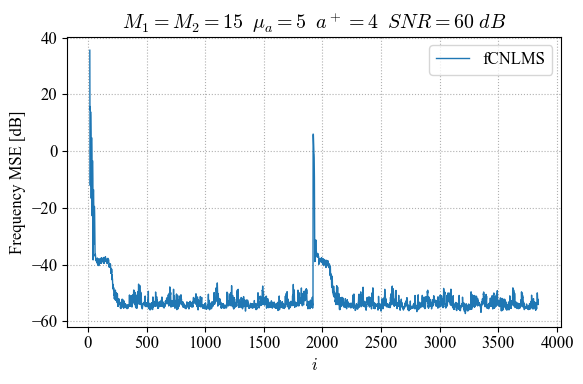

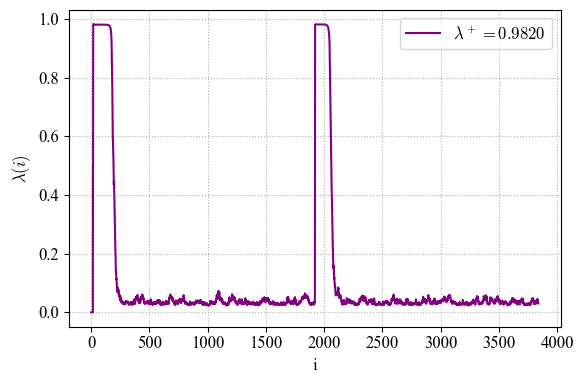

In [27]:
plt.figure(figsize=(6,4))
plt.title(rf'Frequency Tracking using NLMS combination')
# plt.plot(f_f1[0,:]*fs, label=rf'$\mu_1={mu_1}$', linewidth=1)
# plt.plot(f_f2[0,:]*fs, label=rf'$\mu_2={mu_2}$', linewidth=1)
plt.plot(f_fCOMB[0,:]*fs, label=rf'fCNLMS', linewidth=1)
plt.plot(f*fs, label=rf'Target Frequency', linestyle='--', color='r', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency [Hz]')
plt.ylim(min(f*fs)-1, max(f*fs)+1)
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.title(rf'$M_1=M_2={M}$  $\mu_a={mu_a}$  $a^+={a_max}$  $SNR={SNR}~dB$')
# plt.plot(freq_mse_f1_db, label=rf'$\mu_1={mu_1}$', linewidth=1)
# plt.plot(freq_mse_f2_db, label=rf'$\mu_2={mu_2}$', linewidth=1)
plt.plot(freq_mse_fCOMB_db, label=rf'fCNLMS', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency MSE [dB]')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

# mse_f1_db = 10*np.log10(np.mean(se_f1, axis=0))
# mse_f2_db = 10*np.log10(np.mean(se_f2, axis=0))
# mse_fCOMB_db = 10*np.log10(np.mean(se_fCOMB, axis=0))

# plt.figure(figsize=(6,4))
# plt.title(rf'$M_1=M_2={M}$  $\mu_a={mu_a}$  $a^+={a_max}$  $SNR={SNR}~dB$')
# plt.plot(mse_f1_db, label=rf'$\mu_1={mu_1}$', linewidth=1)
# plt.plot(mse_f2_db, label=rf'$\mu_2={mu_2}$', linewidth=1)
# plt.plot(mse_fCOMB_db, label=rf'fCNLMS', linewidth=1)
# plt.ylim([-20, 0])
# plt.xlabel('$i$')
# plt.ylabel('MSE [dB]')
# plt.legend()
# plt.grid(linestyle=':')
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(6,4))
plt.plot(flamb_mean, color='purple', label=rf"$\lambda^+={max(flamb_mean):.4f}$")
plt.xlabel('i')
plt.ylabel(rf'$\lambda(i)$')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()


## NLMS Combination with DIFFERENT filter orders

In [44]:
# NLMS (diff orders) Combination algorithm for Frequency Estimation
L = 60
M_1 = 8
M_2 = 16
a_max_dif = 4
beta = 0.9
eps = 1e-6
mu_1_dif = 0.3
mu_2_dif = 0.03
mu_a_dif = 4

M_L = max(M_1, M_2) # order of the largest predictor  
se_1 = np.zeros((runs, T))
freq_se_1 = np.zeros((runs, T))
f_1 = np.zeros((runs, T))
se_2 = np.zeros((runs, T))
freq_se_2 = np.zeros((runs, T))
f_2 = np.zeros((runs, T))
se_COMB = np.zeros((runs, T))
freq_se_COMB = np.zeros((runs, T))
f_COMB_dif = np.zeros((runs, T))
lamb = np.zeros((runs, T))

for k in range(runs):   
    x = np.zeros(T)
    psi = np.zeros(T)
    v = np.random.randn(T)*np.sqrt(s_v2)
    xim1 = np.zeros((1, M_L))

    y_1 = np.zeros(T)
    e_1 = np.zeros(T)
    y_2 = np.zeros(T)
    e_2 = np.zeros(T)
    y = np.zeros(T)
    e = np.zeros(T)
    c_1 = np.zeros((M_1, 1))
    c_2 = np.zeros((M_2, 1))
    c_1pad = np.zeros((M_L, 1))
    c_2pad = np.zeros((M_L, 1))
    c_COMB = np.zeros((M_L, 1))
    a = 0.0
    p = eps

    for i in range(T):
        psi[i] = 2 * np.pi * np.sum(f[:i+1])
        x[i] = A[i] * np.cos(psi[i] + phi[i]) + v[i]
        
        if i > M_L:
            xim1[0,:] = x[i-1:i-M_L-1:-1]

            y_1[i] = (xim1 @ c_1pad).item()
            y_2[i] = (xim1 @ c_2pad).item()
            y[i] = (xim1 @ c_COMB).item()

            e_1[i] = x[i] - y_1[i]
            se_1[k,i] = e_1[i]**2
            freq_se_1[k,i] = (f[i]*fs - f_1[k,i-1]*fs)**2

            e_2[i] = x[i] - y_2[i]
            se_2[k,i] = e_2[i]**2
            freq_se_2[k,i] = (f[i]*fs - f_2[k,i-1]*fs)**2

            e[i] = x[i] - y[i]
            se_COMB[k,i] = e[i]**2
            freq_se_COMB[k,i] = (f[i]*fs - f_COMB_dif[k,i-1]*fs)**2

            if i % L == 0:
                c_1 = c_COMB.copy()[:M_1]
                c_2 = c_COMB.copy()[:M_2]
            
            c_1 = c_1 + ((mu_1_dif * xim1[0,:M_1].reshape(M_1,1)) / (np.linalg.norm(xim1[0,:M_1])**2 + eps)) * e_1[i]
            c_2 = c_2 + ((mu_2_dif * xim1[0,:M_2].reshape(M_2,1)) / (np.linalg.norm(xim1[0,:M_2])**2 + eps)) * e_2[i]

            c_1pad = np.concatenate((c_1, np.zeros((M_L - M_1, 1))), axis=0) #filling c_k with zeros to match the regressor dimension
            c_2pad = np.concatenate((c_2, np.zeros((M_L - M_2, 1))), axis=0)

            lamb[k, i] = 1/(1 + np.abs(np.exp(-a/2))**2)
            p = beta*p + (1 - beta)*(e_2[i] - e_1[i])**2  # A NORMALIZED ADAPTATION SCHEME FOR THE CONVEX COMBINATION OF TWO ADAPTIVE FILTERS
            a = a + (mu_a_dif/p) * lamb[k,i]*(1 - lamb[k,i])*e[i]*(e_2[i] - e_1[i])
            a = np.clip(a, -a_max_dif, a_max_dif)
            
            c_COMB = lamb[k, i]*c_1pad + (1 - lamb[k, i])*c_2pad

            q1 = np.concatenate((np.array([[1.0]]), -1*c_1.T), axis=1)
            roots_q1 = np.roots(q1[0,:])
            f_1[k, i] = np.angle(roots_q1[np.argmin(np.abs(1 - np.abs(roots_q1)))])/(2*np.pi) 

            q2 = np.concatenate((np.array([[1.0]]), -1*c_2.T), axis=1)
            roots_q2 = np.roots(q2[0,:])
            f_2[k, i] = np.angle(roots_q2[np.argmin(np.abs(1 - np.abs(roots_q2)))])/(2*np.pi)

            q_comb = np.concatenate((np.array([[1.0]]), -1*c_COMB.T), axis=1)
            roots_q_comb = np.roots(q_comb[0,:])
            f_COMB_dif[k, i] = np.angle(roots_q_comb[np.argmin(np.abs(1 - np.abs(roots_q_comb)))])/(2*np.pi)
            

freq_mse_1_dif_db = 10*np.log10(np.mean(freq_se_1, axis=0))
freq_mse_2_dif_db = 10*np.log10(np.mean(freq_se_2, axis=0))
freq_mse_COMB_dif_db = 10*np.log10(np.mean(freq_se_COMB, axis=0))
lamb_dif_mean = np.mean(lamb, axis=0)

C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\3730650320.py:97: RuntimeWarning: divide by zero encountered in log10
  freq_mse_1_dif_db = 10*np.log10(np.mean(freq_se_1, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\3730650320.py:98: RuntimeWarning: divide by zero encountered in log10
  freq_mse_2_dif_db = 10*np.log10(np.mean(freq_se_2, axis=0))
C:\Users\ferna\AppData\Local\Temp\ipykernel_1800\3730650320.py:99: RuntimeWarning: divide by zero encountered in log10
  freq_mse_COMB_dif_db = 10*np.log10(np.mean(freq_se_COMB, axis=0))


In [63]:


plt.figure(figsize=(8,7))
plt.subplot(2, 1, 1)
plt.title(rf'Frequency Tracking using NLMS combination')
# plt.plot(f_1[0,:]*fs, label=rf'$\mu_1={mu_1_dif}$', linewidth=1)
# plt.plot(f_2[0,:]*fs, label=rf'$\mu_2={mu_2_dif}$', linewidth=1)
plt.plot(f_COMB_dif[0,:]*fs, label=rf'CNLMS', linewidth=1)
plt.plot(f*fs, label=rf'Target Frequency', linestyle='--', color='r', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency [Hz]')
plt.ylim(min(f*fs)-1, max(f*fs)+1)
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.title(rf'$M_1=9$  $M_2={M_2}$  $\mu_a={mu_a_dif}$  $SNR={SNR}~dB$')
plt.plot(freq_mse_1_dif_db, label=rf'$\mu_1={mu_1_dif}$', linewidth=1)
plt.plot(freq_mse_2_dif_db, label=rf'$\mu_2={mu_2_dif}$', linewidth=1)
plt.plot(freq_mse_COMB_dif_db, label=rf'CNLMS', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency MSE [dB]')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(lamb_dif_mean, color='purple', label=rf"$\lambda^+={max(lamb_dif_mean):.4f}$")
plt.xlabel('i')
plt.ylabel(rf'$\lambda(i)$')
plt.legend()
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## COMPARISON

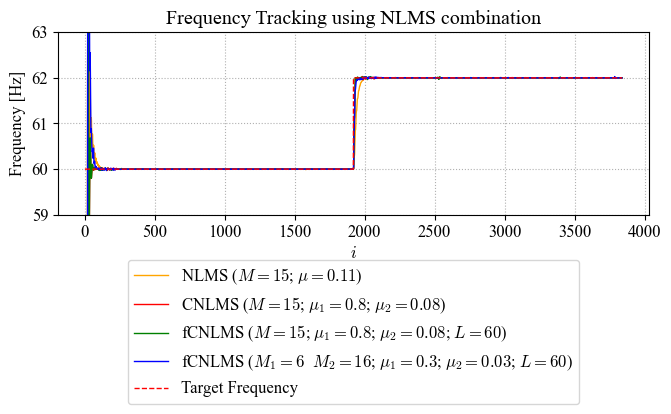

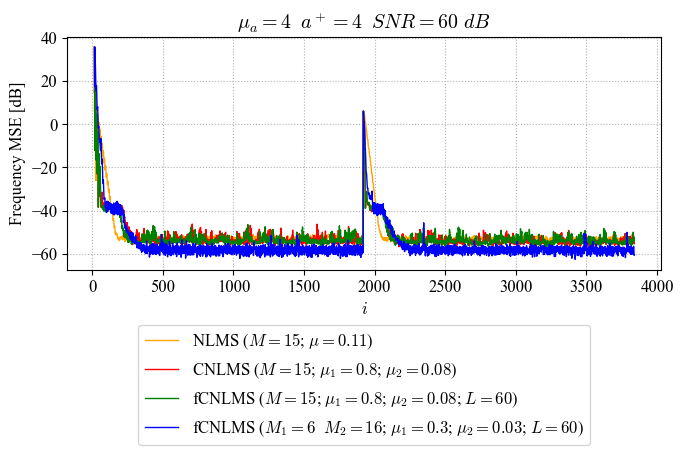

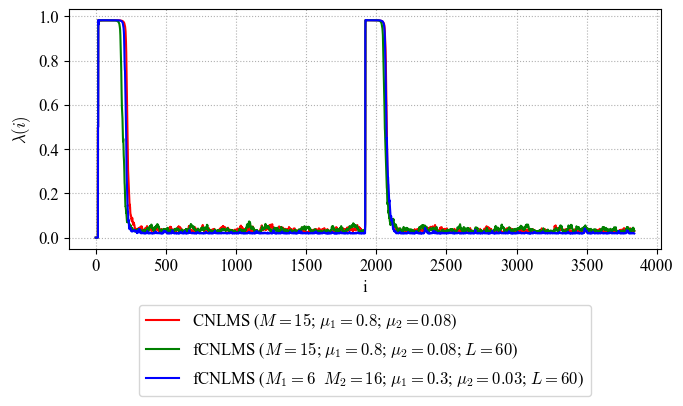

In [40]:
plt.figure(figsize=(7, 4))
plt.title(rf'Frequency Tracking using NLMS combination')
plt.plot(f_NLMS[0,:]*fs, label=rf'NLMS ($M={M}$; $\mu={mu}$)', linewidth=1, color='orange')
plt.plot(f_COMB[0,:]*fs, label=rf'CNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$)', linewidth=1, color='r')
plt.plot(f_fCOMB[0,:]*fs, label=rf'fCNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$; $L={L}$)', linewidth=1, color='g')
plt.plot(f_COMB_dif[0,:]*fs, label=rf'fCNLMS ($M_1={M_1}$  $M_2={M_2}$; $\mu_1={mu_1_dif}$; $\mu_2={mu_2_dif}$; $L={L}$)', linewidth=1, color='b')
plt.plot(f*fs, label=rf'Target Frequency', linestyle='--', color='r', linewidth=1)
plt.xlabel('$i$')
plt.ylabel('Frequency [Hz]')
plt.ylim(min(f*fs)-1, max(f*fs)+1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12)
plt.subplots_adjust(bottom=0.8)
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4.5))
plt.title(rf"$\mu_a={mu_a_dif}$  $a^+={a_max_dif}$  $SNR={SNR}~dB$")
plt.plot(freq_mse_NLMS_db, label=rf'NLMS ($M={M}$; $\mu={mu}$)', linewidth=1, color='orange')
plt.plot(freq_mse_COMB_db, label=rf'CNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$)', linewidth=1, color='r')
plt.plot(freq_mse_fCOMB_db, label=rf'fCNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$; $L={L}$)', linewidth=1, color='g')
plt.plot(freq_mse_COMB_dif_db, label=rf'fCNLMS ($M_1={M_1}$  $M_2={M_2}$; $\mu_1={mu_1_dif}$; $\mu_2={mu_2_dif}$; $L={L}$)', linewidth=1, color='b')
plt.xlabel('$i$')
plt.ylabel('Frequency MSE [dB]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12)
plt.subplots_adjust(bottom=0.6)
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(lamb_mean, label=rf'CNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$)', color='r')
plt.plot(flamb_mean, label=rf'fCNLMS ($M={M}$; $\mu_1={mu_1}$; $\mu_2={mu_2}$; $L={L}$)', color='g')
plt.plot(lamb_dif_mean, label=rf'fCNLMS ($M_1={M_1}$  $M_2={M_2}$; $\mu_1={mu_1_dif}$; $\mu_2={mu_2_dif}$; $L={L}$)', color='b')
plt.xlabel('i')
plt.ylabel(rf'$\lambda(i)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12)
plt.subplots_adjust(bottom=0.6)
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()